In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import torch
import torchvision.transforms as transforms
from dataset import ImageDataset
from PIL import Image
from models import GeneratorResNet, Discriminator, weights_init_normal
from make_args import Args
from torch.utils.data import DataLoader

- args

In [2]:
args = Args('./config/summer2winter_multi_gpu.json')

- dataloader

In [3]:
test_transforms_ = [
    transforms.Resize(int(args.img_height * 1.12), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
testdataset = ImageDataset(args.data_path, transforms_=test_transforms_, unaligned=False, mode='test')
test_dataloader = DataLoader(
    testdataset,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers)

- load trained model

In [4]:
weights = torch.load('./model_result/Summer2Winter/Translation_Model_200epochs.pth')

input_shape = (args.channels, args.img_height, args.img_width)
G_AB = GeneratorResNet(input_shape, args.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, args.n_residual_blocks)
G_AB.load_state_dict(weights['G_AB'])
G_BA.load_state_dict(weights['G_BA'])
G_AB.to("cuda").eval()
G_BA.to("cuda").eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

- inference

In [27]:
se_idx = 3
sample = testdataset[se_idx]
img_A, img_B = sample['A'].unsqueeze(0).to('cuda'), sample['B'].unsqueeze(0).to('cuda')

A2B = G_AB(img_A)
B2A = G_BA(A2B)

- visualization

In [28]:
A2B = np.transpose(A2B[0].data.cpu().numpy(), (1, 2, 0))
B2A = np.transpose(B2A[0].data.cpu().numpy(), (1, 2, 0))

A2B_origin = np.uint8(((A2B * 0.5) + 0.5) * 255)
B2A_origin = np.uint8(((B2A * 0.5) + 0.5) * 255)

img_A_origin = np.transpose(img_A[0].data.cpu().numpy(), (1, 2, 0))
img_A_origin = np.uint8(((img_A_origin * 0.5) + 0.5) * 255)

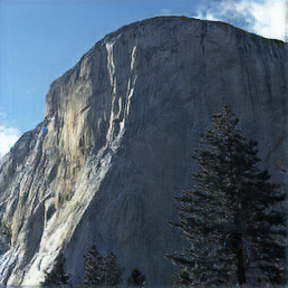

In [29]:
Image.fromarray(A2B_origin)

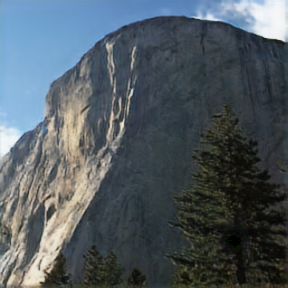

In [30]:
Image.fromarray(B2A_origin)

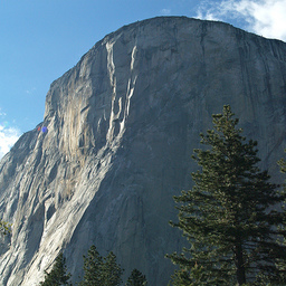

In [31]:
Image.fromarray(img_A_origin)